In [1]:
!pip install fastai==2.5.3
import fastai
fastai.__version__

'2.5.3'

In [2]:
#hide
!pip install -Uqq fastbook

import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *

# Séance 1

## Premier modèle

En exécutant la 1ère cellule ci-dessous:

1. Un jeu de données appelé [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) qui contient 7 349 images de chats et de chiens de 37 races différentes sera téléchargé de la collection de jeux de données fast.ai vers le serveur GPU que vous utilisez, puis extrait.
2. Un *modèle pré-entraîné* sur 1,3 million d'images, en utilisant un modèle gagnant d'une compétition (ImageNet), sera téléchargé.

En exécutant la 2nde cellule ci-dessous:

3. Le modèle pré-entraîné sera *affiné - fine_tune -* (2nde cellule ci-dessous) en utilisant les dernières avancées de l'apprentissage par transfert, pour créer un modèle spécialement personnalisé pour reconnaître les chiens et les chats.

Les deux premières étapes ne seront exécutées qu'une seule fois sur votre serveur GPU. Si vous exécutez à nouveau la cellule, elle utilisera l'ensemble de données et le modèle qui ont déjà été téléchargés, plutôt que de les télécharger à nouveau. Jetons un coup d'œil au contenu de la cellule et aux résultats (<<first_training>>):

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [5]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.172596,0.042509,0.014208,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.056968,0.029759,0.011502,01:19


Vous ne verrez probablement pas exactement les mêmes résultats que ci-dessus. Il existe de nombreuses sources de petites variations aléatoires impliquées dans les modèles d'apprentissage.

> **important:** Durée d'apprentissage: en fonction de la vitesse de votre réseau, cela peut prendre quelques minutes pour le téléchargement du modèle  pré-entraînés et du jeu de données. L'exécution de `fine_tune` peut prendre environ une minute. Souvent, les modèles prennent quelques minutes ou, bien plus à s'entraîner. C'est donc une bonne idée de trouver de bonnes techniques pour tirer le meilleur parti de ce temps. Par exemple, continuez à lire la section suivante pendant que votre modèle s'entraîne, ou ouvrez un autre notebook et utilisez-le pour le codage d'autres expériences.

In [6]:
learn.save("resnet18_chats_chiens")

Path('/root/.fastai/data/oxford-iiit-pet/images/models/resnet18_chats_chiens.pth')

In [ ]:
# learn.load("resnet18_chats_chiens")

### Evaluation du modèle

Alors, comment savoir si ce modèle est bon? Dans la dernière colonne du tableau, vous pouvez voir le taux d'erreur, qui est la proportion d'images incorrectement identifiées. Le taux d'erreur sert de mesure - notre mesure de la qualité du modèle, choisie pour être intuitive et compréhensible. Comme vous pouvez le voir, le modèle est presque parfait, même si le temps d'apprentissage n'était que de quelques secondes (sans compter le téléchargement unique de l'ensemble de données et du modèle pré-entraîné). En fait, la précision que vous avez déjà obtenue est bien meilleure que quiconque n'avait jamais atteint il y a à peine 10 ans!

Enfin, vérifions que ce modèle fonctionne réellement. Allez chercher une photo d'un chien ou d'un chat; si vous n'en avez pas sous la main, recherchez simplement Google Images et téléchargez une image que vous y trouvez. Exécutez maintenant la cellule avec `uploader` défini. Il affichera un bouton sur lequel vous pouvez cliquer, afin que vous puissiez sélectionner l'image que vous souhaitez classer:

In [7]:
#hide_output
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" id="upload" src="https://github.com/iskode/dl22/blob/main/notebooks/images/att_00008.png?raw=1">

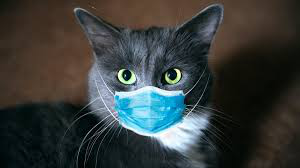

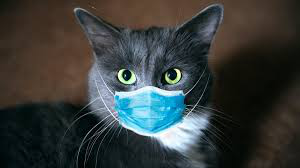

In [8]:
img = PILImage.create(uploader.data[0])
display(img)
img

Vous pouvez maintenant transmettre le fichier téléchargé au modèle. Assurez-vous qu'il s'agit d'une photo claire d'un seul chien ou d'un chat, et non d'un dessin au trait, d'un dessin animé ou similaire. Le cahier vous dira s'il pense que c'est un chien ou un chat et à quel point il est confiant. J'espère que vous constaterez que votre modèle a fait un excellent travail.

In [9]:
is_cat,_,probs = learn.predict(img)
print(f"Est-ce un chat?: {'Oui' if is_cat=='True' else 'Non'}.")
print(f"Probabilité que c'est un chat: {probs[1].item():.6f}")

Est-ce un chat?: Oui.
Probabilité que c'est un chat: 1.000000


Félicitations pour votre premier classifieur profond!

mais qu'est ce que ça veut dire? Qu'avez-vous fait réellement? 

Afin d'expliquer cela, faisons à nouveau un zoom arrière pour avoir une vue d'ensemble.

###  Principe du Machine Learning?

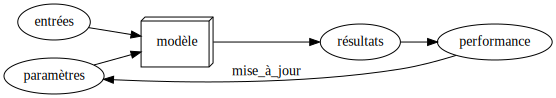

In [10]:
#hide_input
#caption Training a machine learning model
#id training_loop
#alt The basic training loop
gv('''ordering=in
modèle[shape=box3d width=1 height=0.7]
entrées->modèle->résultats; paramètres->modèle; résultats->performance
performance->paramètres[constraint=false label=mise_à_jour]''')

Chaque algorithme d'apprentissage automatique est caractérisé par:
1. la structure du **modèle**, 
1. la mesure **performance** utilisée
1. le mécanisme de **mise-à-jour** de ses paramètres

Pour un NN, nous avons le schéma

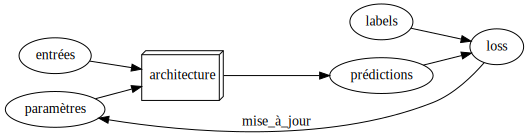

In [11]:
#hide_input
#caption Detailed training loop
#id detailed_loop
gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=architecture]
entrées->model->prédictions; paramètres->model; labels->loss; prédictions->loss
loss->paramètres[constraint=false label=mise_à_jour]''')

Nous verrons par la suite l'architecture utilisée dans notre classifieur. Ici *loss* correspond à la fonction mesurant la performance (jargon du DL). Ces deux dépendent de la tâche à réaliser.


Le mécanisme de *mise_à_jour* est le SGD ou descente du gradient stochastique.
Elle permet de trouver automatiquement le jeu de paramètres permettant au modèle de réaliser correctement la tâche assignée à savoir reconnaître les chats et chiens.
Cette méthode fonctionne quelque soit la tâche à accomplir, l'architecture et le *loss*.

Nous verrons par la suite en détail ces composantes.

### Limitations Inherentes au Machine Learning

À partir de cette image, nous pouvons maintenant voir certaines choses fondamentales sur l'entraînement d'un modèle d'apprentissage profond:

- Un modèle ne peut pas être créé sans données.
- Un modèle ne peut apprendre à opérer que sur les entrées similaires à celles  utilisées pour l'entraîner.
- Cette approche d'apprentissage ne crée que des *prédictions*, et non des *actions*  recommandées.
- Il ne suffit pas d'avoir des exemples de données d'entrée; nous avons également besoin *d'étiquettes* pour ces données (par exemple, les images de chiens et de chats ne suffisent pas pour former un modèle; nous avons besoin d'une étiquette pour chacun d'eux, indiquant lesquels sont des chiens et lesquels sont des chats).

De manière générale, nous avons vu que la plupart des organisations **qui déclarent ne pas disposer de suffisamment de données voulant dire en fait qu'elles ne disposent pas de suffisamment de données *étiquetées***. Si une organisation est intéressée à faire quelque chose dans la pratique avec un modèle, alors il est probable qu'elle ait des données d'entrée sur lesquelles elle prévoit d'exécuter son modèle. Et vraisemblablement, elle le fait d'une autre manière depuis un certain temps (par exemple, manuellement ou avec un programme d'heuristiques), donc elle a des données de ces processus! Par exemple, un cabinet de radiologie aura presque certainement une archive de scans médicaux (car ils doivent pouvoir vérifier la progression de leurs patients au fil du temps), mais ces scans peuvent ne pas avoir d'étiquettes structurées contenant une liste de diagnostics ou d'interventions (étant donnée que les radiologues créent généralement des rapports en langage naturel en texte libre, et non des données structurées). Nous discuterons beaucoup des approches d'étiquetage dans ce livre, car c'est une question très importante dans la pratique.

Étant donné que ces types de modèles d'apprentissage automatique **ne peuvent faire que des *prédictions*** (c'est-à-dire tenter de répliquer des étiquettes), cela peut entraîner **un écart important entre les objectifs organisationnels et les capacités du modèle**. Par exemple, dans ce livre, vous apprendrez à créer un *système de recommandation* qui peut prédire les produits qu'un utilisateur peut acheter. Ceci est souvent utilisé dans le commerce électronique, par exemple pour personnaliser les produits affichés sur une page d'accueil en affichant les articles les mieux classés. Mais un tel modèle est généralement créé en regardant un utilisateur et son historique d'achat (*entrées*) et ce qu'il a ensuite acheté ou regardé (*étiquettes*), ce qui signifie que le modèle est susceptible de vous indiquer des produits l'utilisateur déjà acquis ou connu, plutôt que de nouveaux produits dont il est le plus susceptible d'être intéressé à entendre parler. C'est très différent de ce que, disons, un expert de votre libraire local pourrait faire, où il pose des questions pour déterminer votre goût, puis vous parle d'auteurs ou de séries dont vous n'avez jamais entendu parler auparavant.

Maintenant que vous avez vu la base de la théorie, revenons à notre exemple de code et voyons en détail comment le code correspond au processus que nous venons de décrire.

### Fonctionnement de notre outil de reconnaissance d'images

Voyons comment notre code de reconnaissance d'image correspond à ces idées. Nous allons mettre chaque ligne dans une cellule séparée et regarder ce que chacun fait (nous n'expliquerons pas encore tous les détails de chaque paramètre, mais donnerons une description des éléments importants; tous les détails viendront plus tard dans le livre ).

La première ligne importe toute la bibliothèque fastai.vision.


```python
from fastai.vision.all import *
```

Cela nous donne toutes les fonctions et classes dont nous aurons besoin pour créer une grande variété de modèles de vision par ordinateur.

> J: De nombreux codeurs Python recommandent d'éviter d'importer une bibliothèque entière comme celle-ci (en utilisant la syntaxe `import *`), car dans les grands projets logiciels, cela peut causer des problèmes. Cependant, pour un travail interactif comme dans un notebook Jupyter, cela fonctionne très bien. La bibliothèque fastai est spécialement conçue pour prendre en charge ce type d'utilisation interactive, et elle n'importera que les éléments nécessaires dans votre environnement.

La deuxième ligne télécharge un ensemble de données standard de la [collection d'ensembles de données fast.ai](https://course.fast.ai/datasets) (s'il n'a pas été téléchargé précédemment) sur votre serveur, l'extrait (s'il n'a pas été précédemment extrait) et renvoie un objet `Path` avec l'emplacement extrait:

```python
path = untar_data(URLs.PETS)/'images'
```

> S: Tout au long de mes études sur fast.ai, et même encore aujourd'hui, j'ai beaucoup appris sur les pratiques de codage productives. La bibliothèque fastai et les notebooks fast.ai regorgent de petits conseils qui ont contribué à faire de moi un meilleur programmeur. Par exemple, notez que la bibliothèque fastai ne renvoie pas seulement une chaîne contenant le chemin d'accès à l'ensemble de données, mais un objet `Path`. Il s'agit d'une classe très utile de la bibliothèque standard Python 3 qui facilite grandement l'accès aux fichiers et aux répertoires. Si vous ne l'avez pas encore rencontré, assurez-vous de consulter sa documentation ou un tutoriel et de l'essayer. Notez que le  https://book.fast.ai contient des liens vers des didacticiels recommandés pour chaque chapitre. Je continuerai de vous informer des petits conseils de codage que j'ai trouvés utiles au fur et à mesure que nous les rencontrons.

Dans la troisième ligne, nous définissons une fonction, `is_cat`, qui étiquette les chats en fonction d'une règle basée sur le nom du fichier fourni par les constructeurs de l'ensemble de données:
```python
def is_cat(x): return x[0].isupper()
```

Nous utilisons cette fonction dans la quatrième ligne, qui indique à fastai quel type de jeu de données nous avons et comment il est structuré:

```python
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))
```

Il existe différentes classes pour différents types d'ensembles de données et de problèmes d'apprentissage profond - ici, nous utilisons `ImageDataLoaders`. La première partie du nom de la classe sera généralement le type de données dont vous disposez, comme une image ou du texte.

L'autre information importante que nous devons fournir à fastai est de savoir comment obtenir les étiquettes de l'ensemble de données. Les ensembles de données de vision par ordinateur sont normalement structurés de telle manière que l'étiquette d'une image fait partie du nom de fichier ou du chemin, le plus souvent le nom du dossier parent. fastai fournit un certain nombre de méthodes d'étiquetage standardisées et des moyens d'écrire les vôtres. Ici, nous disons à fastai d'utiliser la fonction `is_cat` que nous venons de définir.

Enfin, nous définissons les «Transform» dont nous avons besoin. Une «Transform» contient du code qui est appliqué automatiquement pendant l'entraînement; fastai inclut de nombreux `Transform`s prédéfinis, et en ajouter de nouveaux est aussi simple que de créer une fonction Python. Il existe deux types: `item_tfms` est appliqué à chaque élément (dans ce cas, chaque élément est redimensionné en un carré de 224 pixels), tandis que` batch_tfms` est appliqué à un *batch ou lot* d'éléments à la fois en utilisant le GPU, ils sont donc particulièrement rapides (nous en verrons de nombreux exemples tout au long de ce livre).

Pourquoi 224 pixels? C'est la taille standard pour des raisons historiques (les anciens modèles pré-entraînés nécessitent exactement cette taille), mais vous pouvez passer à peu près tout. Si vous augmentez la taille, vous obtiendrez souvent un modèle avec de meilleurs résultats (car il pourra se concentrer sur plus de détails), mais au prix de la vitesse et de la consommation de mémoire; le contraire est vrai si vous diminuez la taille.

> Note: Classification et régression: _classification_ et _regression_ ont des significations très spécifiques dans l'apprentissage automatique. Ce sont les deux principaux types de modèles que nous étudierons dans ce livre. Un modèle de classification est un modèle qui tente de prédire une classe ou une catégorie. Autrement dit, il prédit un certain nombre de possibilités discrètes, telles que «chien» ou «chat». Un modèle de régression est un modèle qui tente de prédire une ou plusieurs quantités numériques, telles qu'une température ou une position. Parfois, les gens utilisent le mot «régression» pour désigner un type particulier de modèle appelé «modèle de régression linéaire»; c'est une mauvaise pratique, et nous n'utiliserons pas cette terminologie dans ce livre!

L'ensemble de données sur les animaux contient 7 390 photos de chiens et de chats, soit 37 races différentes. Chaque image est étiquetée en utilisant son nom de fichier: par exemple, le fichier *great \ _pyrenees \ _173.jpg* est le 173ème exemple d'image d'un chien de race Great Pyrenees dans l'ensemble de données. Les noms de fichiers commencent par une lettre majuscule si l'image est un chat et une lettre minuscule dans le cas contraire. Nous devons dire à fastai comment obtenir des étiquettes à partir des noms de fichiers, ce que nous faisons en appelant `from_name_func` (ce qui signifie que les étiquettes peuvent être extraites en utilisant une fonction appliquée au nom de fichier), et en passant` x [0] .isupper () ` , qui prend la valeur «True» si la première lettre est en majuscule (c'est-à-dire que c'est un chat).

Le paramètre le plus important à mentionner ici est `valid_pct = 0.2`. Cela indique à fastai de conserver 20% des données et de *ne pas l'utiliser du tout pour entraîner le modèle*. Ces 20% des données sont appelés le *ensemble de validation*; les 80% restants sont appelés *ensemble d'entraînement*. L'ensemble de validation est utilisé pour mesurer la précision du modèle. Par défaut, les 20% retenus sont sélectionnés au hasard. Le paramètre `seed = 42` définit la * graine aléatoire * à la même valeur chaque fois que nous exécutons ce code, ce qui signifie que nous obtenons le même jeu de validation à chaque fois que nous l'exécutons - de cette façon, si nous changeons notre modèle et le recyclons, nous savons que toutes les différences sont dues aux modifications apportées au modèle, et non à un jeu de validation aléatoire différent.

fastai vous montrera *toujours* la précision de votre modèle en utilisant *uniquement* l'ensemble de validation, *jamais* l'ensemble d'entraînement. Ceci est absolument essentiel, car si vous entraînez un modèle suffisamment grand pendant suffisamment longtemps, il mémorisera éventuellement l'étiquette de chaque élément de votre ensemble de données! Le résultat ne sera pas réellement un modèle utile, car ce qui nous importe, c'est la façon dont notre modèle fonctionne sur *des images jamais vues auparavant*. C'est toujours notre objectif lors de la création d'un modèle: qu'il soit utile sur des données que le modèle ne voit que dans le futur, après avoir été formé.

Même lorsque votre modèle n'a pas entièrement mémorisé toutes vos données, il se peut qu'il en ait mémorisé certaines parties au début de l'entraînement. En conséquence, plus vous vous entraînez longtemps, meilleure sera votre précision sur l'ensemble d'entraînement; la précision de l'ensemble de validation s'améliorera également pendant un certain temps, mais elle finira par empirer à mesure que le modèle commence à mémoriser l'ensemble d'apprentissage, plutôt que de trouver des caractéristiques sous-jacentes généralisables dans les données. Lorsque cela se produit, nous disons que le modèle a *sur-appris*.

<<img_overfit>> montre ce qui se passe lorsque vous sur-apprenez, en utilisant un exemple simplifié où nous n'avons qu'un seul paramètre, et des données générées aléatoirement basées sur la fonction «x ** 2». Comme vous pouvez le voir, bien que les prédictions du modèle ayant sur-appris soient exactes pour les données proches des points de données observés, elles sont très éloignées lorsqu'elles sont en dehors de cette plage.

<img src="https://github.com/iskode/dl22/blob/main/notebooks/images/att_00000.png?raw=1" alt="Example of overfitting" caption="Example of overfitting" id="img_overfit" width="700">

**Le sur-apprentissage(overfitting) est le problème le plus important et le plus difficile** lors de l'entraînement de tous les praticiens de l'apprentissage automatique et de tous les algorithmes. Comme vous le verrez, il est très facile de créer un modèle qui fait un excellent travail pour faire des prédictions sur les données exactes sur lesquelles il a été formé, mais il est beaucoup plus difficile de faire des prédictions précises sur des données que le modèle n'a jamais vues auparavant. Et bien sûr, ce sont les données qui importeront réellement dans la pratique. Par exemple, si vous créez un classifieur de chiffres manuscrit (comme nous le ferons très bientôt!) Et que vous l'utilisez pour reconnaître les nombres écrits sur les chèques, vous ne verrez jamais aucun des nombres sur lesquels le modèle a été entraîné - le chèque aura légèrement différentes variantes d'écriture à traiter. Vous apprendrez de nombreuses méthodes pour éviter le sur-apprentissage dans ce livre. Cependant, vous ne devez utiliser ces méthodes qu'après avoir confirmé que le sur-apprentissage se produit réellement (c'est-à-dire que vous avez réellement observé que la précision de la validation se détériore pendant l'entraînement). Nous voyons souvent des praticiens utiliser des techniques d'entrave de sur-apprentissage même s'ils disposent de suffisamment de données pour ne pas avoir besoin de le faire, aboutissant à un modèle qui peut être moins précis que ce qu'ils auraient pu réaliser.

> important: Ensemble de validation: lorsque vous entraînez un modèle, vous devez _toujours_ avoir à la fois un ensemble d'apprentissage et un ensemble de validation, et ne devez mesurer la précision de votre modèle que sur l'ensemble de validation. Si vous vous entraînez trop longtemps, avec pas assez de données, vous verrez la précision de votre modèle commencer à se détériorer; cela s'appelle _overfitting_. fastai met par défaut `valid_pct` à` 0.2`, donc même si vous oubliez, fastai créera un jeu de validation pour vous!

La cinquième ligne du code entraînant notre outil de reconnaissance d'images indique à fastai de créer un *réseau de neurones convolutifs* (CNN) et spécifie quelle *architecture* utiliser (c'est-à-dire quel type de modèle créer), sur quelles données nous voulons l'entraîner, et quelle *métrique* à utiliser:

``` python
learn = cnn_learner (dls, resnet18, metrics = error_rate)
```

Pourquoi un CNN? C'est l'approche actuelle de pointe pour créer des modèles de vision par ordinateur. Nous allons tout apprendre sur le fonctionnement des CNN dans ce livre. Leur structure est inspirée du fonctionnement du système de vision humaine.

Il existe de nombreuses architectures différentes dans fastai, que nous présenterons dans ce livre (ainsi que comment créer la vôtre). La plupart du temps, cependant, choisir une architecture n'est pas une partie très importante du processus d'apprentissage profond. C'est quelque chose dont les universitaires aiment parler, mais dans la pratique, il est peu probable que vous ayez besoin de passer beaucoup de temps. Il existe des architectures standard qui fonctionnent la plupart du temps, et dans ce cas, nous en utilisons une appelée _ResNet_ dont nous parlerons beaucoup pendant le livre; il est à la fois rapide et précis pour de nombreux ensembles de données et problèmes. Le «18» dans «resnet18» fait référence au nombre de couches dans cette variante de l'architecture (les autres options sont «34», «50», «101» et «152»). Les modèles utilisant des architectures avec plus de couches prennent plus de temps à s'entraîner et sont plus sujets au sur-apprentissage (c'est-à-dire que vous ne pouvez pas les entraîner pendant autant d'époques avant que la précision de l'ensemble de validation ne commence à s'aggraver). D'un autre côté, lorsque vous utilisez plus de données, elles peuvent être un peu plus précises.

Qu'est-ce qu'une métrique? Une *métrique* est une fonction qui mesure la qualité des prédictions du modèle à l'aide du jeu de validation, et sera imprimée à la fin de chaque *époque*. Dans ce cas, nous utilisons `error_rate`, qui est une fonction fournie par fastai qui fait exactement ce qu'elle dit: vous indique quel pourcentage d'images dans le jeu de validation sont classées de manière incorrecte. Une autre métrique courante pour la classification est la «le taux de réussite» (qui est juste «1.0 - error_rate»). fastai en fournit beaucoup d'autres, qui seront discutées tout au long de ce livre.

Le concept de métrique peut vous rappeler une *perte*, mais il y a une distinction importante. Le but entier de la perte est de définir une «mesure de la performance» que le système de formation peut utiliser pour mettre à jour automatiquement les pondérations. En d'autres termes, un bon choix pour la perte est un choix facile à utiliser pour la descente de gradient stochastique. Mais une métrique est définie pour la consommation humaine, donc une bonne métrique est une métrique facile à comprendre pour vous et qui correspond le plus possible à ce que vous voulez que le modèle fasse. Parfois, vous pouvez décider que la fonction de perte est une métrique appropriée, mais ce n'est pas nécessairement le cas.

`cnn_learner` a également un paramètre `pretrained`, qui vaut par défaut `True` (donc il est utilisé dans ce cas, même si nous ne l'avons pas spécifié), qui définit les pondérations de votre modèle sur des valeurs qui ont déjà été entraînées par experts pour reconnaître mille catégories différentes sur 1,3 million de photos (en utilisant le célèbre jeu de données [*ImageNet*](http://www.image-net.org/)). Un modèle dont les poids ont déjà été entraînés sur un autre ensemble de données est appelé un *modèle pré-entraîné*. Vous devriez presque toujours utiliser un modèle pré-entraîné, car cela signifie que votre modèle, avant même que vous ne lui montriez aucune de vos données, est déjà très performant. Et, comme vous le verrez, dans un modèle d'apprentissage en profondeur, bon nombre de ces capacités sont des éléments dont vous aurez besoin, presque indépendamment des détails de votre projet. Par exemple, des parties de modèles pré-entraînés gèrent la détection des bords, des dégradés et des couleurs, qui sont nécessaires pour de nombreuses tâches.

Lors de l'utilisation d'un modèle pré-entraîné, `cnn_learner` supprimera la dernière couche, car celle-ci est toujours spécifiquement personnalisée pour la tâche d'entraînement d'origine (c'est-à-dire la classification de l'ensemble de données ImageNet), et la remplacera par une ou plusieurs nouvelles couches avec des poids aléatoires, d'une taille appropriée. pour l'ensemble de données avec lequel vous travaillez. Cette dernière partie du modèle est connue sous le nom de *tête*.

L'utilisation de modèles pré-entraînés est la méthode *la plus* importante dont nous disposons pour nous permettre de former des modèles plus précis, plus rapidement, avec moins de données, et moins de temps et d'argent. Vous pourriez penser que cela signifierait que l'utilisation de modèles pré-entraînés serait le domaine le plus étudié de l'apprentissage profond académique ... mais vous auriez très, très tort! L'importance des modèles pré-entraînés n'est généralement pas reconnue ou discutée dans la plupart des cours, des livres ou des fonctionnalités de la bibliothèque de logiciels, et est rarement prise en compte dans les articles universitaires. Au moment où nous écrivons ceci au début de 2020, les choses commencent tout juste à changer, mais cela prendra probablement un certain temps. Soyez donc prudent: la plupart des personnes à qui vous parlez sous-estimeront probablement grandement ce que vous pouvez faire en deep learning avec peu de ressources, car elles ne comprendront probablement pas profondément comment utiliser des modèles pré-entraînés.

L'utilisation d'un modèle pré-entraîné pour une tâche différente de celle pour laquelle il a été initialement formé est appelée *apprentissage par transfert*. Malheureusement, parce que l'apprentissage par transfert est tellement sous-étudié, peu de domaines ont des modèles pré-entraînés disponibles. Par exemple, il existe actuellement peu de modèles pré-entraînés disponibles en médecine, ce qui rend l'apprentissage par transfert difficile à utiliser dans ce domaine. De plus, on ne comprend pas encore bien comment utiliser l'apprentissage par transfert pour des tâches telles que l'analyse de séries chronologiques.

> jargon: Apprentissage par transfert: Utilisation d'un modèle pré-entraîné pour une tâche différente de celle pour laquelle il a été entraîné.

La sixième ligne de notre code indique à fastai comment *adapter* le modèle:

``` python
learn.fine_tune (1)
```

Comme nous l'avons vu, l'architecture ne décrit qu'un *modèle* pour une fonction mathématique; il ne fait rien tant que nous ne fournissons pas de valeurs pour les millions de paramètres qu'il contient.

C'est la clé de l'apprentissage en profondeur: déterminer comment ajuster les paramètres d'un modèle pour l'amener à résoudre votre problème. Afin d'adapter un modèle, nous devons fournir au moins une information: combien de fois regarder chaque image (appelé nombre *d'époques*). Le nombre d'époques que vous sélectionnez dépendra en grande partie du temps dont vous disposez et du temps qu'il vous faudra en pratique pour adapter votre modèle. Si vous sélectionnez un nombre trop petit, vous pouvez toujours vous entraîner pour plus d'époques plus tard.

Mais pourquoi la méthode est-elle appelée «fine_tune» et non «fit»? fastai en fait *a* une méthode appelée `fit`, qui correspond effectivement à un modèle (c'est-à-dire regarder les images dans l'ensemble d'entraînement plusieurs fois, en mettant à jour à chaque fois les paramètres pour rendre les prédictions de plus en plus proches des étiquettes cibles). Mais dans ce cas, nous avons commencé avec un modèle pré-entraîné, et nous ne voulons pas jeter toutes les capacités dont il dispose déjà. Comme vous l'apprendrez dans ce livre, il existe quelques astuces importantes pour adapter un modèle pré-entraîné à un nouvel ensemble de données - un processus appelé *affinage*.

> jargon: Fine-tuning: Une technique d'apprentissage par transfert où les paramètres d'un modèle pré-entraîné sont mis à jour par un entraînement à des époques supplémentaires en utilisant une tâche différente de celle utilisée pour le pré-entraînement.

Lorsque vous utilisez la méthode `fine_tune`, fastai utilisera ces astuces pour vous. Il y a quelques paramètres que vous pouvez définir (dont nous parlerons plus tard), mais dans la forme par défaut montré ici, il effectue deux étapes:

1. Utilisez une époque pour ajuster uniquement les parties du modèle nécessaires pour que la nouvelle tête aléatoire fonctionne correctement avec votre jeu de données.
1. Utilisez le nombre d'époques demandé lors de l'appel de la méthode pour s'adapter à l'ensemble du modèle, en mettant à jour les poids des couches ultérieures (en particulier la tête) plus rapidement que les couches précédentes (qui, comme nous le verrons, ne nécessitent généralement pas beaucoup changements par rapport aux paramètres pré-entraînés).

La *tête* d'un modèle est la partie nouvellement ajoutée pour être spécifique au nouvel ensemble de données. Une *époque* est un passage complet à travers l'ensemble de données. Après avoir appelé `fit`, les résultats après chaque époque sont affichés, indiquant le numéro d'époque, les pertes de l'ensemble d'entraînement et de validation (la " mesure de la performance "utilisée pour entraîner le modèle), et toutes les *métriques* que vous avez demandées (erreur taux, dans ce cas).



Ainsi, avec tout ce code, notre modèle a appris à reconnaître les chats et les chiens uniquement à partir d'exemples étiquetés. Mais comment cela s'est-il fait? (voir slides)

### Les outils de reconnaissance d'image peuvent traiter des tâches non liées à l'image

Un outil de reconnaissance d'image ne peut, comme son nom l'indique, reconnaître que des images. Mais beaucoup de choses peuvent être représentées sous forme d'images, ce qui signifie qu'un logiciel de reconnaissance d'images peut apprendre à effectuer de nombreuses tâches.

Par exemple, un son peut être converti en un spectrogramme, qui est un graphique qui montre la quantité de chaque fréquence à chaque instant dans un fichier audio. Ethan Sutin, étudiant de Fast.ai, a utilisé cette approche pour battre facilement l'état-de-l'art publié d'un [modèle de détection des sons environnementaux](https://medium.com/@etown/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52) en utilisant un jeu de données de 8732 sons urbains. «show_batch» de fastai montre clairement comment chaque son différent a un spectrogramme assez distinctif, comme vous pouvez le voir dans <<img_spect>>.

<img alt="show_batch with spectrograms of sounds" width="400" caption="show_batch with spectrograms of sounds" id="img_spect" src="https://github.com/iskode/dl22/blob/main/notebooks/images/att_00012.png?raw=1">

Une série chronologique peut facilement être convertie en image en traçant simplement la série chronologique sur un graphique. Cependant, il est souvent judicieux d'essayer de représenter vos données de manière à ce qu'il soit aussi facile que possible d'extraire les composants les plus importants. Dans une série chronologique, des éléments comme la saisonnalité et les anomalies sont les plus susceptibles d'être intéressants. Il existe diverses transformations disponibles pour les données de séries chronologiques. Par exemple, l'étudiant de fast.ai Ignacio Oguiza a créé des images à partir d'un ensemble de données chronologiques pour la **classification de l'huile d'olive**, en utilisant une technique appelée Gramian Angular Difference Field (GADF); vous pouvez voir le résultat dans <<ts_image>>. Il a ensuite introduit ces images dans un modèle de classification d'images, tout comme celui que vous voyez dans ce chapitre. Ses résultats, bien qu'ils n'aient que 30 images de plateau d'entraînement, étaient précis à plus de 90% et proches de l'état de l'art.

<img alt="Converting a time series into an image" width="700" caption="Converting a time series into an image" id="ts_image" src="https://github.com/iskode/dl22/blob/main/notebooks/images/att_00013.png?raw=1">

Un autre exemple intéressant de projet étudiant fast.ai vient de Gleb Esman. Il travaillait sur la détection de fraude chez Splunk, en utilisant un ensemble de données des mouvements de souris et des clics de souris des utilisateurs. Il les a transformés en images en dessinant une image où la position, la vitesse et l'accélération du pointeur de la souris étaient affichées à l'aide de lignes colorées, et les clics étaient affichés à l'aide de [petits cercles colorés](https://www.splunk.com/en_us/blog/security/deep-learning-with-splunk-and-tensorflow-for-security-catching-the-fraudster-in-neural-networks-with-behavioral-biometrics.html), comme indiqué dans <<splunk>> . Il a ensuite introduit cela dans un modèle de reconnaissance d'image comme celui que nous avons utilisé dans ce chapitre, et cela a si bien fonctionné que cela a conduit à un brevet pour cette approche d'analyse de la fraude!

<img alt="Converting computer mouse behavior to an image" width="450" caption="Converting computer mouse behavior to an image" id="splunk" src="https://github.com/iskode/dl22/blob/main/notebooks/images/att_00014.png?raw=1">

Un autre exemple provient de l'article ["Malware Classification with Deep Convolutional Neural Networks"](https://ieeexplore.ieee.org/abstract/document/8328749) de Mahmoud Kalash et al., Qui explique que "le fichier binaire du malware est divisé en séquences de 8 bits qui sont ensuite converties en valeurs décimales équivalentes. Ce vecteur décimal est remodelé et une image en échelle de gris est générée qui représente l'échantillon de logiciel malveillant, "comme dans <<malware_proc>>.

<img alt="Malware classification process" width="623" caption="Malware classification process" id="malware_proc" src="https://github.com/iskode/dl22/blob/main/notebooks/images/att_00055.png?raw=1">

Les auteurs montrent ensuite des "images" générées par ce processus de malwares dans différentes catégories, comme indiqué dans <<malware_eg>>.

<img alt="Malware examples" width="650" caption="Malware examples" id="malware_eg" src="https://github.com/iskode/dl22/blob/main/notebooks/images/att_00056.png?raw=1">

Comme vous pouvez le voir, les différents types de logiciels malveillants semblent très distinctifs à l'œil humain. Le modèle que les chercheurs ont formé sur la base de cette représentation d'image était plus précis pour la classification des logiciels malveillants que toute autre approche précédente présentée dans la littérature académique. Cela suggère une bonne règle empirique pour convertir un ensemble de données en une représentation d'image: si l'œil humain peut reconnaître des catégories à partir des images, alors un modèle d'apprentissage en profondeur devrait également être en mesure de le faire.

En général, vous constaterez qu'un petit nombre d'approches générales de l'apprentissage profond peuvent aller très loin, si vous êtes un peu créatif dans la façon dont vous représentez vos données! Vous ne devriez pas penser à des approches comme celles décrites ici comme des «solutions de contournement piratées», car en réalité elles battent souvent (comme ici) des résultats auparavant à la pointe de la technologie. Ce sont vraiment les bonnes façons de penser concernant ce genre de problèmes.

### Jargon Recap

Nous venons de couvrir beaucoup d'informations, alors récapitulons brièvement, <<dljargon>> fournit un vocabulaire pratique.

| Terme | Sens|
| :--- | :--- |
| Étiquette(label) | Les données que nous essayons de prédire, telles que "chien" ou "chat"
| Architecture | Le _template_ du modèle que nous essayons d'adapter; la fonction mathématique réelle à laquelle nous transmettons les données d'entrée et les paramètres
| Modèle | La combinaison de l'architecture avec un ensemble particulier de paramètres
| Paramètres | Les valeurs du modèle qui modifient la tâche qu'il peut effectuer et qui sont mises à jour via la formation du modèle
| fit | Mettre à jour les paramètres du modèle de sorte que les prédictions du modèle utilisant les données d'entrée correspondent aux étiquettes cibles
| Entraîner | Un synonyme de _fit_
| Modèle pré-entraîné | Un modèle qui a déjà été formé, utilisant généralement un grand ensemble de données, et qui sera affiné
| fine_tune| Mettre à jour un modèle pré-entraîné pour une tâche différente
| Epoque (epoch) | Un passage complet dans les données d'entrée
| Perte | Une mesure de la qualité du modèle, choisi pour conduire la formation via SGD
| Métrique | Une mesure de la qualité du modèle, à l'aide de l'ensemble de validation, choisi pour la consommation humaine
| Ensemble de validation | Un ensemble de données issues de la formation, utilisé uniquement pour mesurer la qualité du modèle
| Ensemble d'entraînement | Les données utilisées pour ajuster le modèle; n'inclut aucune donnée du jeu de validation
| Sur-apprentissage | Entraîner un modèle de manière à se souvenir des caractéristiques spécifiques des données d'entrée, plutôt que de bien généraliser à des données non vues pendant l'entraînement
| CNN | Réseau de neurones convolutifs; un type de réseau neuronal qui fonctionne particulièrement bien pour les tâches de vision par ordinateur


Avec ce vocabulaire en main, nous sommes désormais en mesure de rassembler tous les concepts clés introduits jusqu'à présent. Prenez un moment pour revoir ces définitions et lisez le résumé suivant. Si vous pouvez suivre l'explication, alors vous êtes bien équipé pour comprendre les discussions à venir.

*L'apprentissage automatique* est une discipline dans laquelle nous définissons un programme non pas en l'écrivant entièrement nous-mêmes, mais en apprenant à partir de données. *L'apprentissage profond* est une spécialité de l'apprentissage automatique qui utilise des *réseaux de neurones* avec plusieurs *couches*. *La classification d'image* est un exemple représentatif (également appelé *reconnaissance d'images*). Nous commençons par des *données étiquetées*; c'est-à-dire un ensemble d'images où nous avons attribué une *étiquette* à chaque image indiquant ce qu'elle représente. Notre objectif est de produire un programme, appelé un *modèle*, qui, étant donné une nouvelle image, fera une *prédiction* précise de ce que cette nouvelle image représente.

Chaque modèle commence par un choix d '*architecture*, un modèle général expliquant comment ce type de modèle fonctionne en interne. Le processus d'*entraînement* (ou *ajustement*) du modèle est le processus de recherche d'un ensemble de *valeurs de paramètres* (ou *poids*) qui spécialisent cette architecture générale dans un modèle qui fonctionne bien pour notre type particulier de données. Afin de définir les performances d'un modèle sur une seule prédiction, nous devons définir une *fonction de perte*, qui détermine comment nous évaluons une prédiction comme bonne ou mauvaise.

Pour accélérer le processus d'entraînement, nous pouvons commencer avec un *modèle pré-entraîné* - un modèle qui a déjà été entraîné sur les données de quelqu'un d'autre. Nous pouvons ensuite l'adapter à nos données en l'entraînant un peu plus sur nos données, un processus appelé *affinage (fine_tune)*.

Lorsque nous entraînons un modèle, une préoccupation clé est de s'assurer que notre modèle *se généralise*, c'est-à-dire qu'il tire des leçons générales de nos données qui s'appliquent également aux nouveaux éléments qu'il rencontrera, afin qu'il puisse faire de bonnes prédictions sur ces éléments . Le risque est que si nous formons mal notre modèle, au lieu d'apprendre des leçons générales, il mémorise effectivement ce qu'il a déjà vu, et alors il fera de mauvaises prédictions sur les nouvelles images. Un tel échec est appelé *sur-apprentissage*. Afin d'éviter cela, nous divisons toujours nos données en deux parties, l'*ensemble d'apprentissage* et l' *ensemble de validation*. Nous entraînons le modèle en ne lui montrant que l'ensemble d'apprentissage, puis nous évaluons les performances du modèle en observant ses performances sur les éléments de l'ensemble de validation. De cette manière, nous vérifions si les leçons que le modèle tire de l'ensemble d'entraînement sont des leçons qui se généralisent à l'ensemble de validation. Afin qu'une personne puisse évaluer les performances du modèle sur l'ensemble de validation, nous définissons une *métrique*. Pendant le processus d'apprentissage, lorsque le modèle a vu chaque élément de l'ensemble d'apprentissage, nous appelons cela une *époque*.

Tous ces concepts s'appliquent à l'apprentissage automatique en général. Autrement dit, ils s'appliquent à toutes sortes de schémas pour définir un modèle en l'entraînant avec des données. Ce qui distingue le deep learning, c'est une classe particulière d'architectures: les architectures basées sur des *réseaux de neurones*. En particulier, des tâches comme la classification d'images reposent fortement sur les *réseaux de neurones convolutifs*, dont nous parlerons sous peu.

Une brève explication en une ligne est fournie par `doc`. Le lien "Afficher dans la documentation" vous amène à la documentation complète, où vous trouverez tous les détails et de nombreux exemples. De plus, la plupart des méthodes de fastai ne sont que quelques lignes, vous pouvez donc cliquer sur le lien «source» pour voir exactement ce qui se passe dans les coulisses.

### Sidebar: Jeu de données : La nourriture des modèles

En matière d'apprentissage automatique et d'apprentissage en profondeur, nous ne pouvons rien faire sans données. Ainsi, les personnes qui créent des ensembles de données sur lesquels nous pouvons former nos modèles sont les héros (souvent sous-estimés). Certains des ensembles de données les plus utiles et les plus importants sont ceux qui deviennent des *références académiques* importantes; c'est-à-dire des ensembles de données largement étudiés par les chercheurs et utilisés pour comparer les changements algorithmiques. Certains d'entre eux deviennent des noms familiers (du moins parmi les ménages qui forment des modèles!), Tels que MNIST, CIFAR-10 et ImageNet.

Les ensembles de données utilisés dans ce livre ont été sélectionnés car ils fournissent d'excellents exemples des types de données que vous êtes susceptible de rencontrer, et la littérature académique a de nombreux exemples de résultats de modèles utilisant ces ensembles de données auxquels vous pouvez comparer votre travail.

La plupart des ensembles de données utilisés dans ce livre ont demandé beaucoup de travail aux auteurs. Par exemple, plus loin dans le livre, nous vous montrerons comment créer un modèle capable de traduire entre le français et l'anglais. La principale contribution à cela est un corpus de textes parallèles français / anglais préparé en 2009 par le professeur Chris Callison-Burch de l'Université de Pennsylvanie. Cet ensemble de données contient plus de 20 millions de paires de phrases en français et en anglais. Il a construit l'ensemble de données d'une manière vraiment intelligente: en explorant des millions de pages Web canadiennes (qui sont souvent multilingues), puis en utilisant un ensemble d'heuristiques simples pour transformer les URL de contenu français en URL pointant vers le même contenu en anglais.

En examinant les ensembles de données tout au long de ce livre, réfléchissez à leur origine et à la manière dont ils auraient pu être conservés. Pensez ensuite aux types d'ensembles de données intéressants que vous pourriez créer pour vos propres projets. (Nous vous guiderons même étape par étape tout au long du processus de création de votre propre ensemble de données d'image bientôt.)

fast.ai a passé beaucoup de temps à créer des versions réduites d'ensembles de données populaires spécialement conçus pour prendre en charge le prototypage rapide et l'expérimentation, et pour être plus faciles à apprendre. Dans ce livre, nous commencerons souvent par utiliser l'une des versions réduites et par la suite passer à la version pleine grandeur (comme nous le faisons dans ce chapitre!). En fait, c’est ainsi que les meilleurs praticiens du monde font leur modélisation dans la pratique; ils font la plupart de leurs expériences et prototypes avec des sous-ensembles de leurs données, et n'utilisent l'ensemble de données complet que lorsqu'ils ont une bonne compréhension de ce qu'ils doivent faire.

### End sidebar

Chacun des modèles que nous avons entraînés a montré une perte de formation et de validation. Un bon ensemble de validation est l'un des éléments les plus importants du processus de formation. Voyons pourquoi et apprenons à en créer un.

## Ensembles de Validation et de  Test

Comme nous l'avons vu, le but d'un modèle est de faire des prédictions sur les données. Mais le processus d'entraînement du modèle est fondamentalement stupide. Si nous entraînions un modèle avec toutes nos données, puis évaluions le modèle à l'aide de ces mêmes données, nous ne serions pas en mesure de déterminer dans quelle mesure notre modèle peut fonctionner sur des données qu'il n'a pas vues. Sans cette information très précieuse pour nous guider dans la formation de notre modèle, il y a de très bonnes chances qu'il devienne bon pour faire des prédictions sur ces données, mais qu'il fonctionne mal sur de nouvelles données.

Pour éviter cela, notre première étape a été de diviser notre ensemble de données en deux ensembles: le *ensemble d'entraînement* (que notre modèle voit dans l'entraînement) et le *ensemble de validation*, également appelé *ensemble de développement* (qui n'est utilisé que pour évaluation). Cela nous permet de tester que le modèle tire des leçons des données d'entraînement qui se généralisent à de nouvelles données, les données de validation.

Une façon de comprendre cette situation est que, dans un sens, nous ne voulons pas que notre modèle obtienne de bons résultats en «trichant». S'il fait une prédiction précise pour un élément de données, cela devrait être parce qu'il a appris les caractéristiques de ce type d'élément, et non parce que le modèle a été façonné en *ayant effectivement vu cet élément particulier*.

Le fractionnement de nos données de validation signifie que notre modèle ne les voit jamais à l'entraînement et qu'il n'en est donc pas du tout entaché, et ne triche en aucun cas. Est-ce correct?

En fait, pas nécessairement. La situation est plus subtile. En effet, dans des scénarios réalistes, nous construisons rarement un modèle en entraînant une seule fois ses paramètres. Au lieu de cela, nous explorerons probablement de nombreuses versions d'un modèle à travers divers choix de modélisation concernant l'architecture du réseau, les rythmes d'apprentissage, les stratégies d'augmentation des données et d'autres facteurs dont nous parlerons dans les prochains chapitres. Beaucoup de ces choix peuvent être décrits comme des choix *d'hyperparamètres*. Le mot indique qu'il s'agit de paramètres relatifs aux paramètres, car ce sont les choix de niveau supérieur qui régissent la signification des paramètres.

Le problème est que même si le processus d'entraînement ordinaire ne regarde que les prédictions sur les données d'entraînement lorsqu'il apprend des valeurs pour les paramètres, il n'en va pas de même pour nous. En tant que modélisateurs, nous évaluons le modèle en examinant les prédictions sur les données de validation lorsque nous décidons d'explorer de nouvelles valeurs d'hyperparamètres! Ainsi, les versions ultérieures du modèle sont, indirectement, façonnées par nous après avoir vu les données de validation. Tout comme le processus d'entraînement automatique risque de sur-apprendre les données d'entraînement, nous risquons de sur-apprendre les données de validation par le biais d'essais et d'erreurs humains et d'exploration.

La solution à cette énigme est d'introduire un autre niveau de données encore plus hautement réservées, le *test set*. Tout comme nous retenons les données de validation du processus de formation, nous devons retenir les données de l'ensemble de test même de nous-mêmes. Il ne peut pas être utilisé pour améliorer le modèle; il ne peut être utilisé que pour évaluer le modèle à la toute fin de nos efforts. En effet, nous définissons une hiérarchie de coupes de nos données, en fonction de la mesure dans laquelle nous voulons les cacher des processus d'entraînement et de modélisation: les données d'entraînement sont entièrement exposées, les données de validation sont moins exposées et les données de test sont totalement masquées. Cette hiérarchie met en parallèle les différents types de processus de modélisation et d'évaluation eux-mêmes - le processus d'entraînement automatique avec rétro-propagation, le processus plus manuel consistant à essayer différents hyper-paramètres entre les séances d'entraînement et l'évaluation de notre résultat final.

Les ensembles de test et de validation doivent contenir suffisamment de données pour garantir une bonne estimation de votre précision. Si vous créez un détecteur de chat, par exemple, vous voulez généralement au moins 30 chats dans votre ensemble de validation. Cela signifie que si vous avez un jeu de données avec des milliers d'éléments, l'utilisation de la taille de jeu de validation par défaut de 20% peut être plus que ce dont vous avez besoin. D'un autre côté, si vous avez beaucoup de données, en utiliser une partie pour la validation n'a probablement aucun inconvénient.

Avoir deux niveaux de «données réservées» - un ensemble de validation et un ensemble de test, avec un niveau représentant des données que vous vous cachez virtuellement - peut sembler un peu extrême. Mais la raison pour laquelle cela est souvent nécessaire est que les modèles ont tendance à s'orienter vers le moyen le plus simple de faire de bonnes prédictions (mémorisation), et que nous, humains faillibles, avons tendance à nous tromper sur les performances de nos modèles. La discipline de l'ensemble de tests nous aide à rester intellectuellement honnêtes. Cela ne veut pas dire que nous avons *toujours* besoin d'un ensemble de tests séparé - si vous avez très peu de données, vous devrez peut-être simplement avoir un ensemble de validation - mais il est généralement préférable d'en utiliser un si possible.

Cette même discipline peut être critique si vous avez l'intention d'embaucher un tiers pour effectuer des travaux de modélisation en votre nom. Un tiers peut ne pas comprendre vos exigences avec précision, ou ses incitations peuvent même les inciter à mal les  comprendre. Un bon ensemble de tests peut considérablement atténuer ces risques et vous permettre d'évaluer si leur travail résout votre problème réel.

Pour le dire franchement, si vous êtes un décideur senior dans votre organisation (ou si vous conseillez des décideurs seniors), le point le plus important à retenir est le suivant: si vous vous assurez de bien comprendre ce que sont les ensembles de test et de validation et pourquoi ils est important, alors vous éviterez la plus grande source d'échecs que nous ayons vue lorsque les organisations décident d'utiliser l'IA. Par exemple, si vous envisagez de faire appel à un fournisseur ou à un service externe, assurez-vous de conserver des données de test que le fournisseur *ne pourra jamais voir*. Ensuite *vous* vérifiez leur modèle sur vos données de test, en utilisant une métrique que *vous* choisissez en fonction de ce qui compte réellement pour vous dans la pratique, et *vous* décidez du niveau de performance adéquat. (C'est également une bonne idée pour vous d'essayer vous-même une base de référence simple, afin de savoir ce qu'un modèle vraiment simple peut réaliser. Souvent, il s'avérera que votre modèle simple fonctionne aussi bien que celui produit par un "expert" externe !)

### Juger pour définir un ensemble de Test

Pour bien définir un ensemble de validation (et éventuellement un ensemble de test), vous voudrez parfois faire plus que simplement saisir au hasard une fraction de votre ensemble de données d'origine. N'oubliez pas: une propriété clé des ensembles de validation et de test est qu'ils doivent être représentatifs des nouvelles données que vous verrez dans le futur. Cela peut sembler un ordre impossible! Par définition, vous n’avez pas encore vu ces données. Mais vous savez généralement encore certaines choses.

Il est instructif d'examiner quelques exemples de cas. Beaucoup de ces exemples proviennent de concours de modélisation prédictive sur la plate-forme [Kaggle](https://www.kaggle.com/), qui est une bonne représentation des problèmes et des méthodes que vous pourriez voir dans la pratique.

Un cas peut être si vous regardez des données de séries chronologiques. Pour une série chronologique, le choix d'un sous-ensemble aléatoire de données sera à la fois trop facile (vous pouvez consulter les données avant et après les dates que vous essayez de prédire) et non représentatif de la plupart des cas d'utilisation commerciaux (où vous utilisez l'historique données pour construire un modèle à utiliser dans le futur). Si vos données incluent la date et que vous créez un modèle à utiliser à l'avenir, vous voudrez choisir une section continue avec les dernières dates comme ensemble de validation (par exemple, les deux dernières semaines ou le dernier mois de données disponibles).

Supposons que vous souhaitiez diviser les données de la série chronologique dans <<timeseries1>> en ensembles d'apprentissage et de validation.

<img src="https://github.com/iskode/dl22/blob/main/notebooks/images/timeseries1.png?raw=1" width="400" id="timeseries1" caption="A time series" alt="A serie of values">

Un sous-ensemble aléatoire est un mauvais choix (trop facile à combler, et non indicatif de ce dont vous aurez besoin en production), comme nous pouvons le voir dans <<timeseries2>>.

<img src="https://github.com/iskode/dl22/blob/main/notebooks/images/timeseries2.png?raw=1" width="400" id="timeseries2" caption="A poor training subset" alt="Random training subset">

À la place, utilisez les données antérieures comme ensemble d'entraînement (et les données ultérieures pour l'ensemble de validation), comme indiqué dans <<timeseries3>>.

<img src="https://github.com/iskode/dl22/blob/main/notebooks/images/timeseries3.png?raw=1" width="400" id="timeseries3" caption="A good training subset" alt="Training subset using the data up to a certain timestamp">

Par exemple, Kaggle avait une compétition pour [prévoir les ventes dans une chaîne d'épiceries équatoriennes](https://www.kaggle.com/c/favorita-grocery-sales-forecasting). Les données d'entraînement de Kaggle se sont déroulées du 1er janvier 2013 au 15 août 2017, et les données de test s'étalaient du 16 août 2017 au 31 août 2017. De cette façon, l'organisateur du concours s'est assuré que les participants faisaient des prédictions pour une période qui était *dans le futur*, du point de vue de leur modèle. Ceci est similaire à la façon dont les traders de fonds spéculatifs quantitatifs effectuent des *back-testing* pour vérifier si leurs modèles sont prédictifs des périodes futures, sur la base de données passées.

Un deuxième cas courant est celui où vous pouvez facilement anticiper la manière dont les données pour lesquelles vous allez faire des prédictions en production peuvent être *qualitativement différentes* des données avec lesquelles vous devez entraîner votre modèle.

Dans la [compétition du conducteur distrait](https://www.kaggle.com/c/state-farm-distraced-driver-detection) de Kaggle, les variables indépendantes sont des images de conducteurs au volant d'une voiture, et les variables dépendantes sont des catégories telles que les textos, manger ou regarder devant en toute sécurité. De nombreuses images représentent les mêmes pilotes dans des positions différentes, comme nous pouvons le voir dans <<img_driver>> (ci-dessous). Si vous étiez une compagnie d'assurance qui construisait un modèle à partir de ces données, notez que vous seriez très intéressé par la façon dont le modèle fonctionne sur les conducteurs qu'elle n'a jamais vus auparavant (puisque vous n'auriez probablement des données d'entraînement que pour un petit groupe de personnes). En reconnaissance de cela, les données de test pour la compétition consistent en des images de personnes qui n'apparaissent pas dans l'ensemble d'entraînement.

<img src="https://github.com/iskode/dl22/blob/main/notebooks/images/driver.PNG?raw=1" width="600" id="img_driver" caption="Two pictures from the training data" alt="Two pictures from the training data, showing the same driver">

Si vous mettez une des images de <<img_driver>> ((ci-dessus) dans votre ensemble d'entraînement et une dans l'ensemble de validation, votre modèle aura un temps facile à faire une prédiction pour celle dans l'ensemble de validation, donc il semblera mieux fonctionner que sur de nouvelles personnes. Une autre perspective est que si vous avez utilisé toutes les personnes dans la formation de votre modèle, votre modèle pourrait être sur-entraîné aux particularités de ces personnes spécifiques, et pas seulement apprendre les états (textos, manger, etc.).

Une dynamique similaire était à l'œuvre dans le [Concours de la pêche Kaggle](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring) pour identifier les espèces de poissons capturées par les bateaux de pêche afin de réduire la pêche illégale des populations menacées. L'ensemble de test était composé de bateaux qui n'apparaissaient pas dans les données d'entraînement. Cela signifie que vous souhaitez que votre jeu de validation inclue les bateaux qui ne sont pas dans le jeu d'entraînement.

Parfois, la différence entre vos données de validation peut ne pas être claire. Par exemple, pour un problème d'utilisation d'images satellite, vous devez collecter plus d'informations pour savoir si l'ensemble d'entraînement contient uniquement certains emplacements géographiques ou s'il provient de données dispersées géographiquement.

## TP 1

### I. Prise en main:

Exécuter le code de notre outil de reconnaissance puis évaluer sur une image chien et de chat de votre choix.


### II. Evaluation d'une variante architecturale
1. Entraînez (code séparé) l'outil de reconnaissance sur même architecture (resnet) mais avec 34 couches en profondeur. 
1. Comparez les durée d'entraînement et performance à la version précédente.

### III. Evaluation d'une modification sur les données
1. Modifiez le dataloader (`dls`) pour charger des images de taille 300x300. 
2. Visualisez les images en exécutant la méthode `show_batch()` sur ce dernier.  
3. Entraîner de nouveau (code séparé) l'outil de reconnaissance la même architecture de 18 couches en profondeur en utilisant des images de taille 300x300.
4. Comparez les durée d'entraînement et performance à la première version précédente.

### IV. Classification des 37 races animales du jeu de données Oxford-iiit-pet
1. Accédez à l'attribut `items` de `dls` pour identifier la classe ou race animales de chaque image. Citez 3 races différentes que vous trouverez. 
2. Définissez une fonction pour extraire le nom de la race à partir du nom du fichier d'une image.  
3. Utilisez la méthode prédéfinie adéquate pour visualiser quelques images et leurs classes conjointement. 
4. Entraînez (code séparé), en conservant les hyperparamètres initiaux, un classifieur capable de différencier entre les 37 races animales.